# Sentiment Analysis on IMDB Reviews with LSTM

## Preparation 

### Import libraries

In [1]:
# Built-in
import os
import json
from zipfile import ZipFile

# Data manipulation
import numpy as np
import pandas as pd

# Data visualization
import seaborn as sns

# Data prep
from sklearn.model_selection import train_test_split

# Deep learning algorithm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

### Global Variables Declaration

In [2]:
random_state = 2024
current_dir = os.getcwd()

### Kaggle API setup

In [3]:
with open(current_dir + r'\\..\kaggle.json', 'r') as f:
    kaggle_cred = json.load(f)
    os.environ['KAGGLE_USERNAME'] = kaggle_cred['username']
    os.environ['KAGGLE_KEY'] = kaggle_cred['key']

In [4]:
!kaggle datasets download -d lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

Dataset URL: https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews
License(s): other
imdb-dataset-of-50k-movie-reviews.zip: Skipping, found more recently modified local copy (use --force to force download)


In [5]:
with ZipFile(current_dir + r'\imdb-dataset-of-50k-movie-reviews.zip', 'r') as zip_file:
    zip_file.extractall()

## Data Prep

### Importing

In [6]:
df = pd.read_csv(current_dir + r'\IMDB Dataset.csv')

In [7]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [9]:
df.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


<Axes: xlabel='sentiment', ylabel='count'>

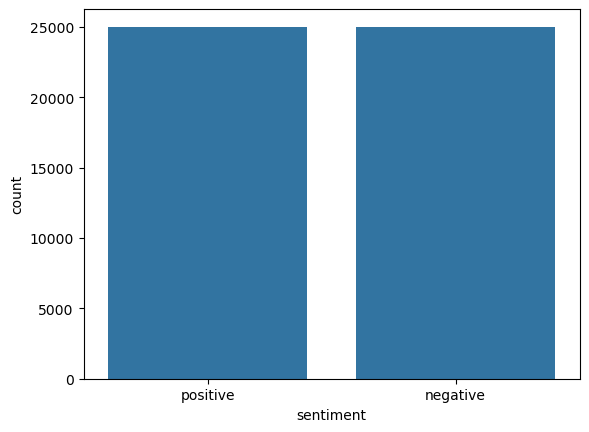

In [10]:
sns.barplot(df.sentiment.value_counts())

In [11]:
df.sentiment = df.sentiment.map({'positive': 1, 'negative': 0})

In [12]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


### Split data into Train and Test subsets

In [13]:
X, y = df.iloc[:, :-1], df.iloc[:, -1]

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=random_state)

In [15]:
print(df.shape, X_train.shape, X_test.shape)

(50000, 2) (40000, 1) (10000, 1)


### Tokenize text data

In [16]:
tokenizer = Tokenizer(num_words=5000)                                                # Require tokenizer to consider only the most 5000 frequency words 
tokenizer.fit_on_texts(X_train['review'])                                            # Update the dictionary
X_train = pad_sequences(tokenizer.texts_to_sequences(X_train['review']), maxlen=200) # Transform each word to the vector of
X_test = pad_sequences(tokenizer.texts_to_sequences(X_test['review']), maxlen=200)   # length 200

In [17]:
print(X_train)

[[   0    0    0 ...  367  157  157]
 [  42  487   46 ...   21   52   49]
 [  27    4   57 ...  539  375    9]
 ...
 [   0    0    0 ...  659   16   77]
 [ 141    3   14 ...   22   21   68]
 [   0    0    0 ...    5   65 3708]]


In [18]:
print(X_test)

[[   0    0    0 ...    6 2362    4]
 [   0    0   10 ...    8    3 3166]
 [   0    0    0 ...    8    1   19]
 ...
 [   0    0    0 ...   13  615 2235]
 [   0    0    0 ...    1 2232  313]
 [   0    0    0 ...   93  146 1617]]


## Model building

### Model declaration

In [28]:
model = Sequential([
    Embedding(input_dim=5000, output_dim=128),
    LSTM(128, dropout=.2, recurrent_dropout=.2),
    Dense(1, activation='sigmoid'),
])

In [29]:
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [30]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

### Model training

In [31]:
model.fit(X_train, y_train, epochs=5, batch_size=64, validation_split=.2)

Epoch 1/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 69s 135ms/step - accuracy: 0.7184 - loss: 0.5372 - val_accuracy: 0.8520 - val_loss: 0.3522
Epoch 2/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 61s 123ms/step - accuracy: 0.8502 - loss: 0.3565 - val_accuracy: 0.8577 - val_loss: 0.3546
Epoch 3/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 61s 122ms/step - accuracy: 0.8642 - loss: 0.3350 - val_accuracy: 0.7830 - val_loss: 0.5064
Epoch 4/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 73s 146ms/step - accuracy: 0.8817 - loss: 0.2919 - val_accuracy: 0.8719 - val_loss: 0.3098
Epoch 5/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 70s 140ms/step - accuracy: 0.8996 - loss: 0.2587 - val_accuracy: 0.8701 - val_loss: 0.3216


### Model evaluation

In [32]:
loss, accuracy = model.evaluate(X_test, y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.8655 - loss: 0.3317


In [35]:
print(f'''
    TEST RESULT
    Loss:     {loss}
    Accuracy: {accuracy}
''')


    TEST RESULT
    Loss:     0.3325962424278259
    Accuracy: 0.8644999861717224



### Save model

In [34]:
model.save(current_dir + '/../model/SentimentAnalysisonIDBM.keras')